PyTorch cung cấp hai dữ liệu gốc:
1.   **torch.utils.data.Dataset** : lưu trữ các mẫu và nhãn tương ứng của chúng
2.   **torch.utils.data.DataLoader** : một vòng lặp xung quanh Datasetđể cho phép dễ dàng truy cập vào các mẫu.

**root** là đường dẫn lưu trữ dữ liệu đào tạo/kiểm tra,

**train** chỉ định tập dữ liệu huấn luyện hoặc kiểm tra,

**download=True** tải xuống dữ liệu từ internet nếu nó không có sẵn tại root.

**transform** và **target_transform** chỉ định các phép biến đổi tính năng và nhãn

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:03<00:00, 7815530.21it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 62781.02it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 493288.39it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5096123.91it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



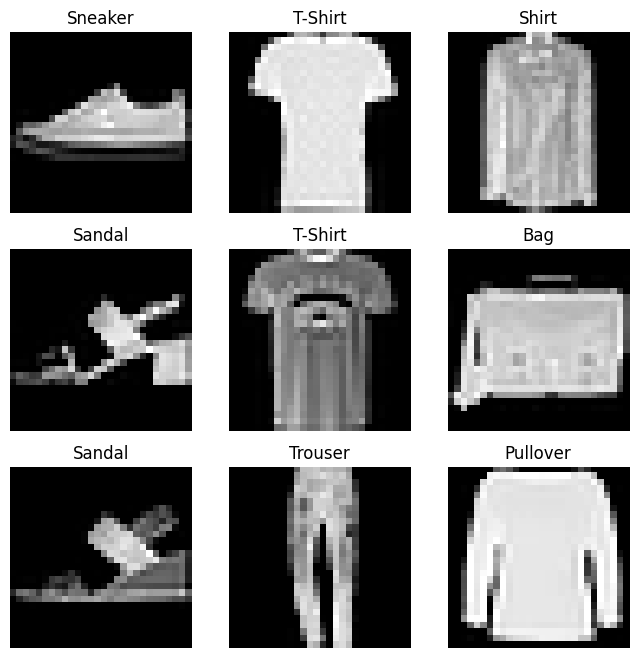

In [ ]:
# Trưc quan hóa dữ liệu , dùng matplotlib để hiển thị các nhãn và label
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Tạo tập dữ liệu và tùy chỉnh
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    # Hàm __init__ được chạy một lần khi khởi tạo đối tượng Dataset
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # Hàm __len__ trả về số lượng mẫu trong tập dữ liệu của chúng tôi.
    def __len__(self):
        return len(self.img_labels)

    # Hàm __getitem__ tải và trả về mẫu từ tập dữ liệu tại chỉ mục đã cho idx.
    # Dựa trên chỉ mục, nó xác định vị trí của hình ảnh trên đĩa, chuyển đổi nó thành một tensor bằng cách sử dụng read_image,
    # truy xuất nhãn tương ứng từ dữ liệu csv trong self.img_labels, gọi các hàm biến đổi trên chúng (nếu có) và trả về hình ảnh tensor và nhãn tương ứng trong một bộ dữ liệu
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# Chuẩn bị dữ liệu để đào tạo với DataLoaders
from torch.utils.data import DataLoader

# Tạo DataLoader cho tập huấn luyện và tập kiểm tra
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


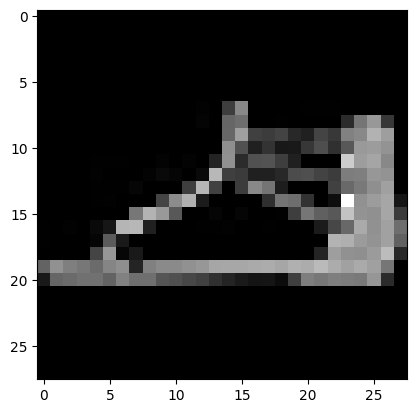

Label: 5


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
import torch
import torch.nn as nn #nearul net
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Kiểm tra xem máy có GPU không , nếu không có chạy trên CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # input 1 channel, output 32 channel, kernel size 3*3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)

        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.dropout1(x)
        # Flatten (Làm phẳng) to vector to input the neural network
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
def test(model, loss_fn, test_data):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in test_data:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            test_loss += loss_fn(y_hat, y).item()
            test_acc += (y_hat.argmax(1) == y).sum().item()

    test_loss /= len(test_data)
    test_acc /= len(test_data)
    return test_loss, test_acc

In [ ]:
# Hàm training
def training_loop(n_epochs, optimizer, model, loss_fn, train_data, test_data):
    losses = []
    test_losses = []
    test_accuracy = []
    iters = 0
    for epoch in range(1, n_epochs + 1):
      for batch in train_data:
        iters += 1
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if iters % 100 == 0:
          print('iters %d, Loss %f' % (iters, float(loss)))
      losses.append(loss.item())
      test_loss, test_acc = test(model, loss_fn, test_data)
      test_losses.append(test_loss)
      test_accuracy.append(test_acc)
      print('epoch %d, Loss %f' % (epoch, float(loss)))
      print('test_loss %f, test_acc %f' % (test_loss, test_acc))
    return losses, test_losses, test_accuracy

In [ ]:
loss, test_loss, test_accuracy = training_loop(
  n_epochs = 6,
  optimizer = optimizer,
  model = net,
  loss_fn = loss_fn,
  train_data = train_dataloader,
  test_data = test_dataloader
)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


iters 100, Loss 2.284351
iters 200, Loss 2.282516
iters 300, Loss 2.279308
iters 400, Loss 2.270075
iters 500, Loss 2.254166
iters 600, Loss 2.254381
iters 700, Loss 2.229310
iters 800, Loss 2.223063
iters 900, Loss 2.174686
epoch 1, Loss 2.168649
test_loss 2.170052, test_acc 31.509554
iters 1000, Loss 2.168635
iters 1100, Loss 2.111614
iters 1200, Loss 2.065228
iters 1300, Loss 2.013917
iters 1400, Loss 1.892476
iters 1500, Loss 1.835987
iters 1600, Loss 1.757734
iters 1700, Loss 1.575005
iters 1800, Loss 1.469854
epoch 2, Loss 1.432371
test_loss 1.430789, test_acc 37.292994
iters 1900, Loss 1.459290
iters 2000, Loss 1.350246
iters 2100, Loss 1.263011
iters 2200, Loss 1.088966
iters 2300, Loss 1.145832
iters 2400, Loss 1.101485
iters 2500, Loss 1.058682
iters 2600, Loss 1.128207
iters 2700, Loss 0.960149
iters 2800, Loss 0.985539
epoch 3, Loss 1.116061
test_loss 0.960176, test_acc 41.286624
iters 2900, Loss 1.021014
iters 3000, Loss 0.967522
iters 3100, Loss 0.937401
iters 3200, Loss 

Text(0, 0.5, 'loss')

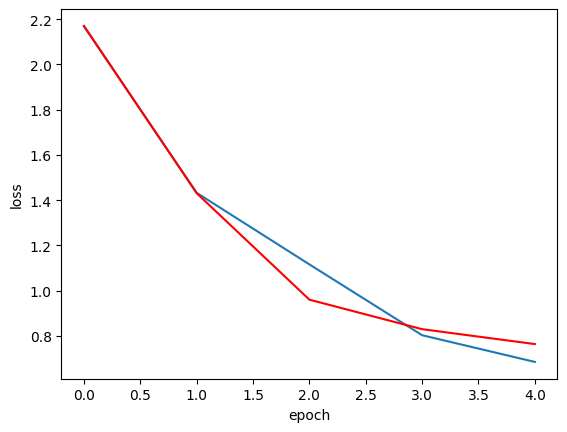

In [ ]:
plt.plot(loss, label="train loss")
plt.plot(test_loss, color='red', label="test loss")
plt.xlabel('epoch')
plt.ylabel('loss')